In [65]:
#####################################################################################################################
#                                                                                                                   #
# Libraries                                                                                                         #
#                                                                                                                   #
#####################################################################################################################
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.rcParams['figure.dpi'] = 200 # Plot resolution (dpi)
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import random
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.vector_ar.var_model import VAR # Import VAR class
import shap
from scipy import stats
from itertools import combinations





In [66]:
file_path = '/Users/bodamjerry/Downloads/GermanyMacroData/'
os.chdir(file_path)
print(f"Current working directory: {os.getcwd()}")

t_Data_Dir = 'TData/'
r_State_Dir = "RState/"
f_result_Dir = "ForecastResults/"
m_result_Dir = "MAEsResults/"
r_result_Dir = "RMSEsResults/"


Current working directory: /Users/bodamjerry/Downloads/GermanyMacroData


In [67]:

forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
mae_results = {}
rmse_results = {}

for steps in forecast_horizons:
    filename_mae = f"maess_{steps}_month_ahead.csv"
    filename_rmse = f"rmses_{steps}_month_ahead.csv"
    try:
        df_mae = pd.read_csv(os.path.join(m_result_Dir, filename_mae))
        df_rmse = pd.read_csv(os.path.join(r_result_Dir, filename_rmse))
        mean_maes = df_mae.mean()
        mean_rmses = df_rmse.mean()
        mae_results[f"{steps}_month_ahead"] = mean_maes.to_dict()
        rmse_results[f"{steps}_month_ahead"] = mean_rmses.to_dict()
    except FileNotFoundError:
        print(f"Error: File '{filename_mae}' or '{filename_rmse}' not found for {steps}-month ahead.")

print("\nMean MAE and RMSE for each model across different forecast horizons:")
for horizon in mae_results.keys():
    print(f"\n{horizon}:")
    mae_means = mae_results.get(horizon, {})
    rmse_means = rmse_results.get(horizon, {})
    for model in mae_means.keys():
        mean_mae = mae_means.get(model, float('nan'))
        mean_rmse = rmse_means.get(model, float('nan'))
        print(f"  {model}: MAE={mean_mae:.4f}, RMSE={mean_rmse:.4f}")


Mean MAE and RMSE for each model across different forecast horizons:

1_month_ahead:
  CNN-LSTM: MAE=0.7483, RMSE=0.9969
  CNN-LSTM + VS: MAE=0.7472, RMSE=0.9967
  SARIMA: MAE=0.7616, RMSE=1.0089
  ARIMA: MAE=0.7595, RMSE=1.0081
  VAR: MAE=1.0213, RMSE=1.3029

2_month_ahead:
  CNN-LSTM: MAE=0.7485, RMSE=0.9963
  CNN-LSTM + VS: MAE=0.7480, RMSE=0.9955
  SARIMA: MAE=0.7613, RMSE=1.0086
  ARIMA: MAE=0.7596, RMSE=1.0082
  VAR: MAE=1.0223, RMSE=1.3012

3_month_ahead:
  CNN-LSTM: MAE=0.7490, RMSE=0.9963
  CNN-LSTM + VS: MAE=0.7481, RMSE=0.9973
  SARIMA: MAE=0.7613, RMSE=1.0085
  ARIMA: MAE=0.7596, RMSE=1.0082
  VAR: MAE=1.0349, RMSE=1.3164

4_month_ahead:
  CNN-LSTM: MAE=0.7490, RMSE=0.9973
  CNN-LSTM + VS: MAE=0.7482, RMSE=0.9970
  SARIMA: MAE=0.7615, RMSE=1.0086
  ARIMA: MAE=0.7595, RMSE=1.0082
  VAR: MAE=1.0383, RMSE=1.3182

5_month_ahead:
  CNN-LSTM: MAE=0.7494, RMSE=0.9987
  CNN-LSTM + VS: MAE=0.7478, RMSE=0.9968
  SARIMA: MAE=0.7617, RMSE=1.0088
  ARIMA: MAE=0.7597, RMSE=1.0081
  VAR:

In [68]:

forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
models = ["CNN-LSTM", "CNN-LSTM + VS", "SARIMA", "ARIMA", "VAR"]
alpha = 0.05  # Significance level
normality_results_all_horizons = {}

print("Normality Tests (Shapiro-Wilk) for Model Performance (MAE):\n")

# --- First Pass: Test for Normality ---
for steps in forecast_horizons:
    filename = f"maess_{steps}_month_ahead.csv"
    normality_results_for_horizon = {}
    try:
        df_maes = pd.read_csv(os.path.join(m_result_Dir, filename))
        print(f"--- Forecast Horizon: {steps}_month_ahead ---")
        for model in models:
            try:
                statistic, p_value = stats.shapiro(df_maes[model])
                is_normal = p_value > alpha
                normality_results_for_horizon[model] = is_normal
                print(f"  Model: {model}, Shapiro-Wilk Statistic: {statistic:.4f}, P-value: {p_value:.4f}, Likely Normal: {is_normal}")
            except Exception as e:
                print(f"  Error during normality test for {model}: {e}")
                normality_results_for_horizon[model] = False # Assume not normal if error
        normality_results_all_horizons[f"{steps}_month_ahead"] = normality_results_for_horizon
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found for {steps}-month ahead.\n")
        normality_results_all_horizons[f"{steps}_month_ahead"] = {model: False for model in models}

print("\nPairwise Significance Tests based on Normality (alpha=0.05):\n")


Normality Tests (Shapiro-Wilk) for Model Performance (MAE):

--- Forecast Horizon: 1_month_ahead ---
  Model: CNN-LSTM, Shapiro-Wilk Statistic: 0.9684, P-value: 0.0167, Likely Normal: False
  Model: CNN-LSTM + VS, Shapiro-Wilk Statistic: 0.9666, P-value: 0.0122, Likely Normal: False
  Model: SARIMA, Shapiro-Wilk Statistic: 0.9768, P-value: 0.0752, Likely Normal: True
  Model: ARIMA, Shapiro-Wilk Statistic: 0.9763, P-value: 0.0687, Likely Normal: True
  Model: VAR, Shapiro-Wilk Statistic: 0.9805, P-value: 0.1455, Likely Normal: True
--- Forecast Horizon: 2_month_ahead ---
  Model: CNN-LSTM, Shapiro-Wilk Statistic: 0.9743, P-value: 0.0477, Likely Normal: False
  Model: CNN-LSTM + VS, Shapiro-Wilk Statistic: 0.9695, P-value: 0.0204, Likely Normal: False
  Model: SARIMA, Shapiro-Wilk Statistic: 0.9753, P-value: 0.0564, Likely Normal: True
  Model: ARIMA, Shapiro-Wilk Statistic: 0.9762, P-value: 0.0673, Likely Normal: True
  Model: VAR, Shapiro-Wilk Statistic: 0.9872, P-value: 0.4502, Likel

In [28]:
# --- Second Pass: Perform Significance Tests ---
for steps in forecast_horizons:
    filename = f"maess_{steps}_month_ahead.csv"
    try:
        df_maes = pd.read_csv(os.path.join(m_result_Dir, filename))
        normality_results_for_horizon = normality_results_all_horizons.get(f"{steps}_month_ahead", {})
        print(f"--- Forecast Horizon: {steps}_month_ahead ---")
        for model_pair in combinations(models, 2):
            model1, model2 = model_pair
            mae_model1 = df_maes[model1]
            mae_model2 = df_maes[model2]
            is_normal_model1 = normality_results_for_horizon.get(model1, False)
            is_normal_model2 = normality_results_for_horizon.get(model2, False)

            print(f"  Comparing {model1} vs {model2}:")
            if is_normal_model1 and is_normal_model2:
                # Perform Independent Samples t-test
                statistic, p_value = stats.ttest_ind(mae_model1, mae_model2)
                test_name = "Independent Samples t-test"
            else:
                # Perform Mann-Whitney U test
                statistic, p_value = stats.mannwhitneyu(mae_model1, mae_model2, alternative='two-sided') # Using 'two-sided' as a general approach
                test_name = "Mann-Whitney U test"

            significant = p_value < alpha
            print(f"    Test: {test_name}, Statistic: {statistic:.4f}, P-value: {p_value:.4f}, Significant Difference (alpha={alpha}): {significant}")

    except FileNotFoundError:
        print(f"Error: File '{filename}' not found for {steps}-month ahead, skipping significance tests.\n")

--- Forecast Horizon: 1_month_ahead ---
  Comparing CNN-LSTM vs CNN-LSTM + VS:
    Test: Mann-Whitney U test, Statistic: 5068.0000, P-value: 0.8690, Significant Difference (alpha=0.05): False
  Comparing CNN-LSTM vs SARIMA:
    Test: Mann-Whitney U test, Statistic: 4495.0000, P-value: 0.2177, Significant Difference (alpha=0.05): False
  Comparing CNN-LSTM vs ARIMA:
    Test: Mann-Whitney U test, Statistic: 4557.0000, P-value: 0.2796, Significant Difference (alpha=0.05): False
  Comparing CNN-LSTM vs VAR:
    Test: Mann-Whitney U test, Statistic: 247.0000, P-value: 0.0000, Significant Difference (alpha=0.05): True
  Comparing CNN-LSTM + VS vs SARIMA:
    Test: Mann-Whitney U test, Statistic: 4431.0000, P-value: 0.1648, Significant Difference (alpha=0.05): False
  Comparing CNN-LSTM + VS vs ARIMA:
    Test: Mann-Whitney U test, Statistic: 4501.0000, P-value: 0.2232, Significant Difference (alpha=0.05): False
  Comparing CNN-LSTM + VS vs VAR:
    Test: Mann-Whitney U test, Statistic: 261.

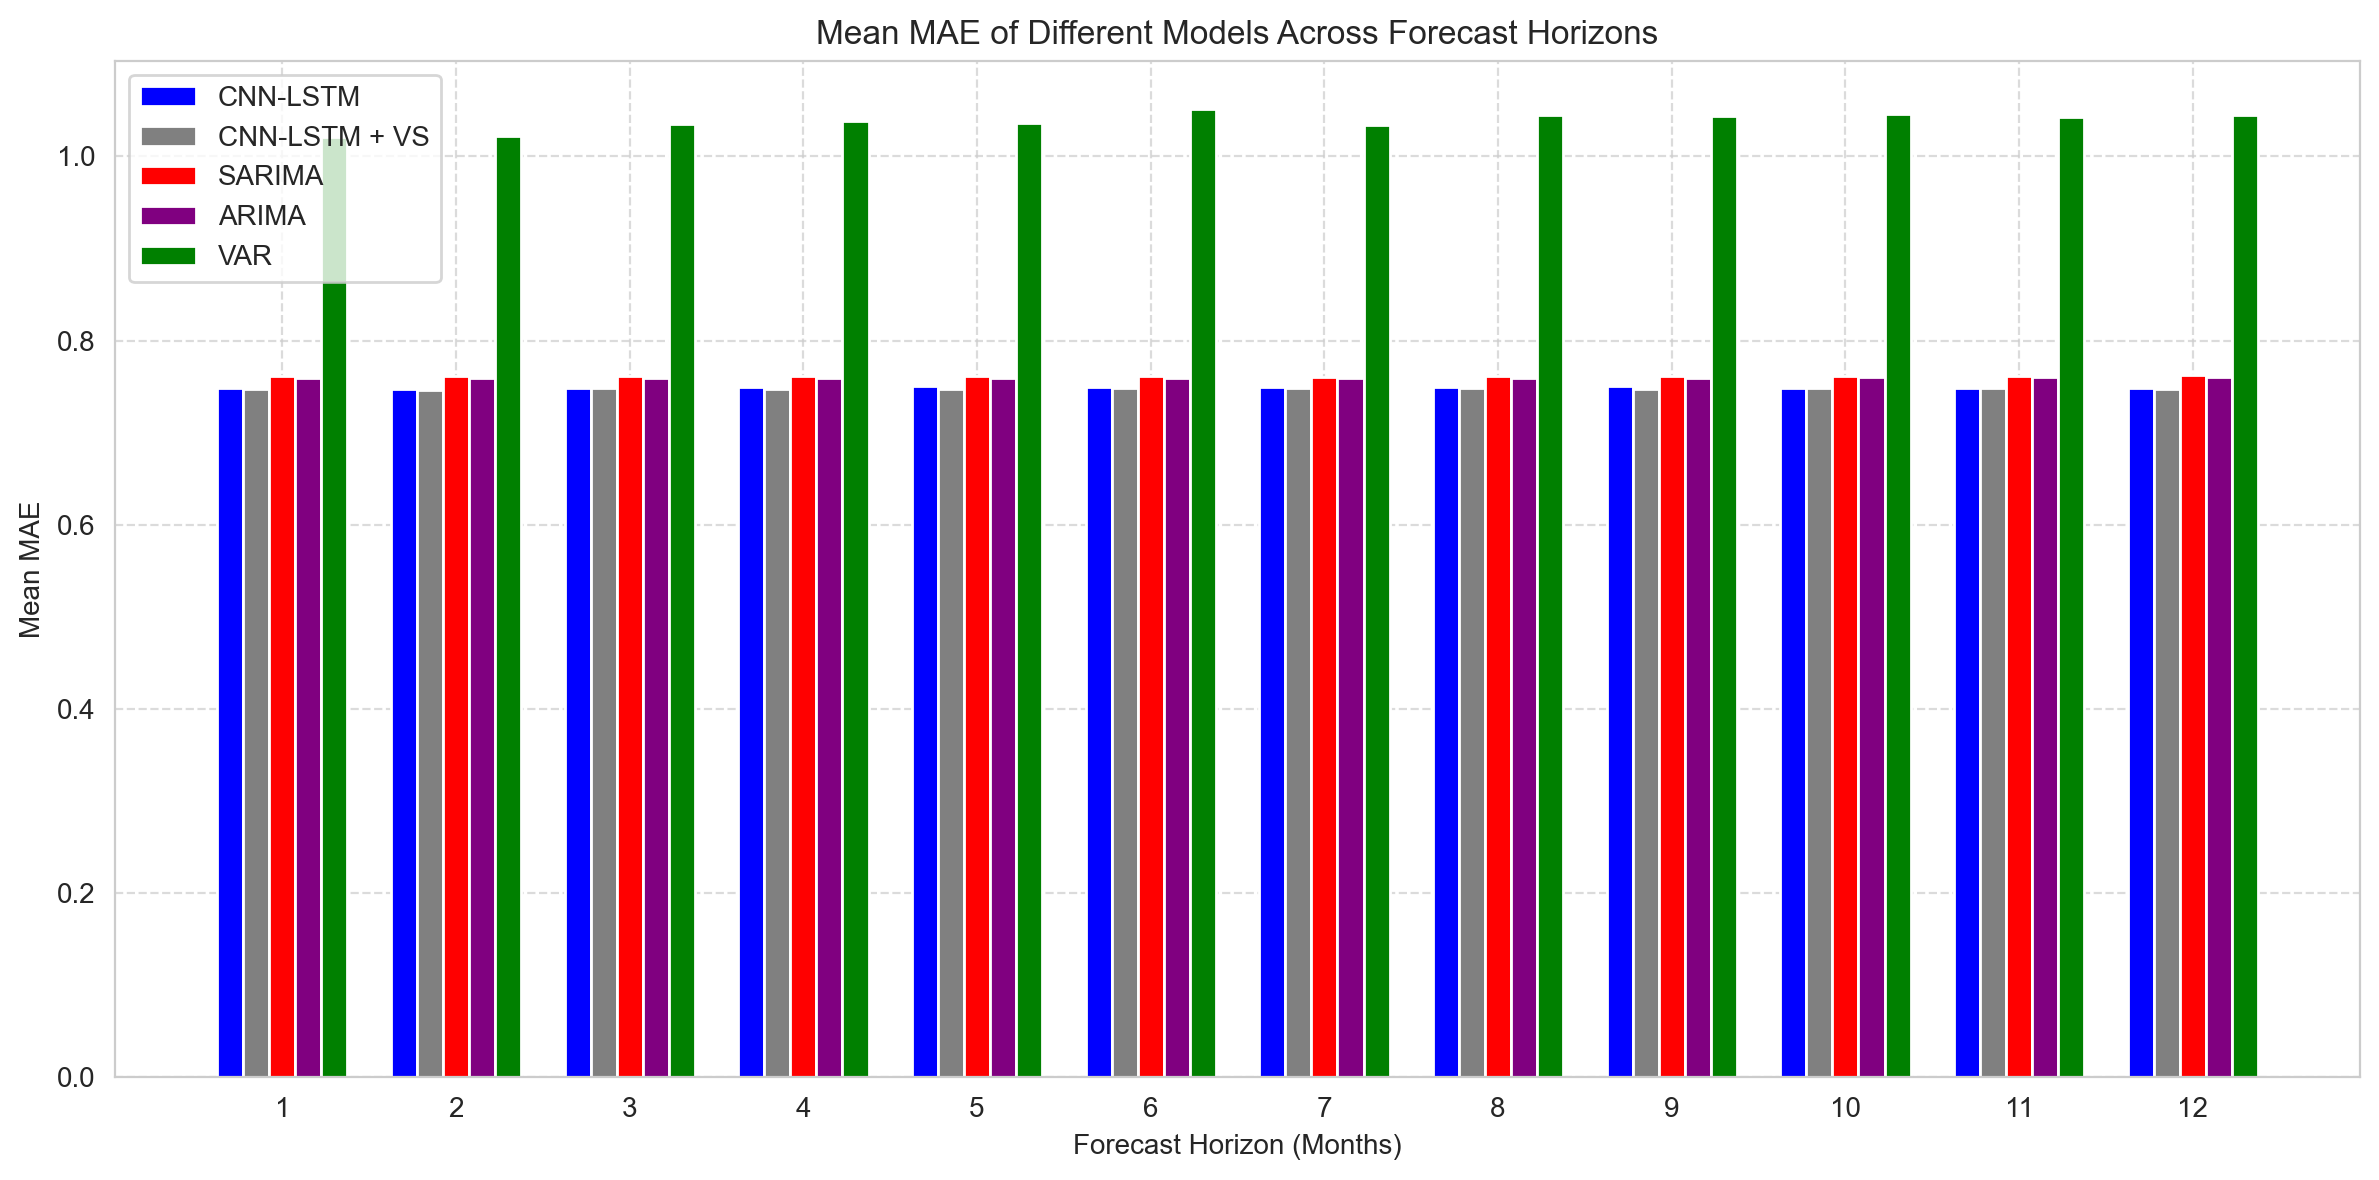

In [31]:

# Assuming mae_results dictionary is populated as in your previous code

forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
models = ["CNN-LSTM", "CNN-LSTM + VS", "SARIMA", "ARIMA", "VAR"]
mae_results = {} # This should be populated from your file reading

for steps in forecast_horizons:
    filename_mae = f"maess_{steps}_month_ahead.csv"
    try:
        df_mae = pd.read_csv(os.path.join(m_result_Dir, filename_mae))
        mean_maes = df_mae.mean()
        mae_results[steps] = mean_maes.to_dict()
    except FileNotFoundError:
        print(f"Error: File '{filename_mae}' not found for {steps}-month ahead.")
        mae_results[steps] = {model: np.nan for model in models} # Use NaN if file not found

# Prepare data for plotting
num_horizons = len(forecast_horizons)
num_models = len(models)
bar_width = 0.15
index = np.arange(num_horizons)

fig, ax = plt.subplots(figsize=(12, 6))

colors = ['blue', 'gray', 'red', 'purple', 'green'] # Define colors for each model
rects = []

for i, model in enumerate(models):
    mae_values = [mae_results[horizon].get(model, np.nan) for horizon in forecast_horizons]
    x_positions = index + (i * bar_width) - (num_models * bar_width / 2) + (bar_width / 2)
    rect = ax.bar(x_positions, mae_values, bar_width, label=model, color=colors[i])
    rects.append(rect)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Forecast Horizon (Months)')
ax.set_ylabel('Mean MAE')
ax.set_title('Mean MAE of Different Models Across Forecast Horizons')
ax.set_xticks(index)
ax.set_xticklabels(forecast_horizons)
ax.legend()

ax.grid(True, linestyle='--', alpha=0.7)
fig.tight_layout()

plt.show()

<function matplotlib.pyplot.xticks(ticks: 'ArrayLike | None' = None, labels: 'Sequence[str] | None' = None, *, minor: 'bool' = False, **kwargs) -> 'tuple[list[Tick] | np.ndarray, list[Text]]'>

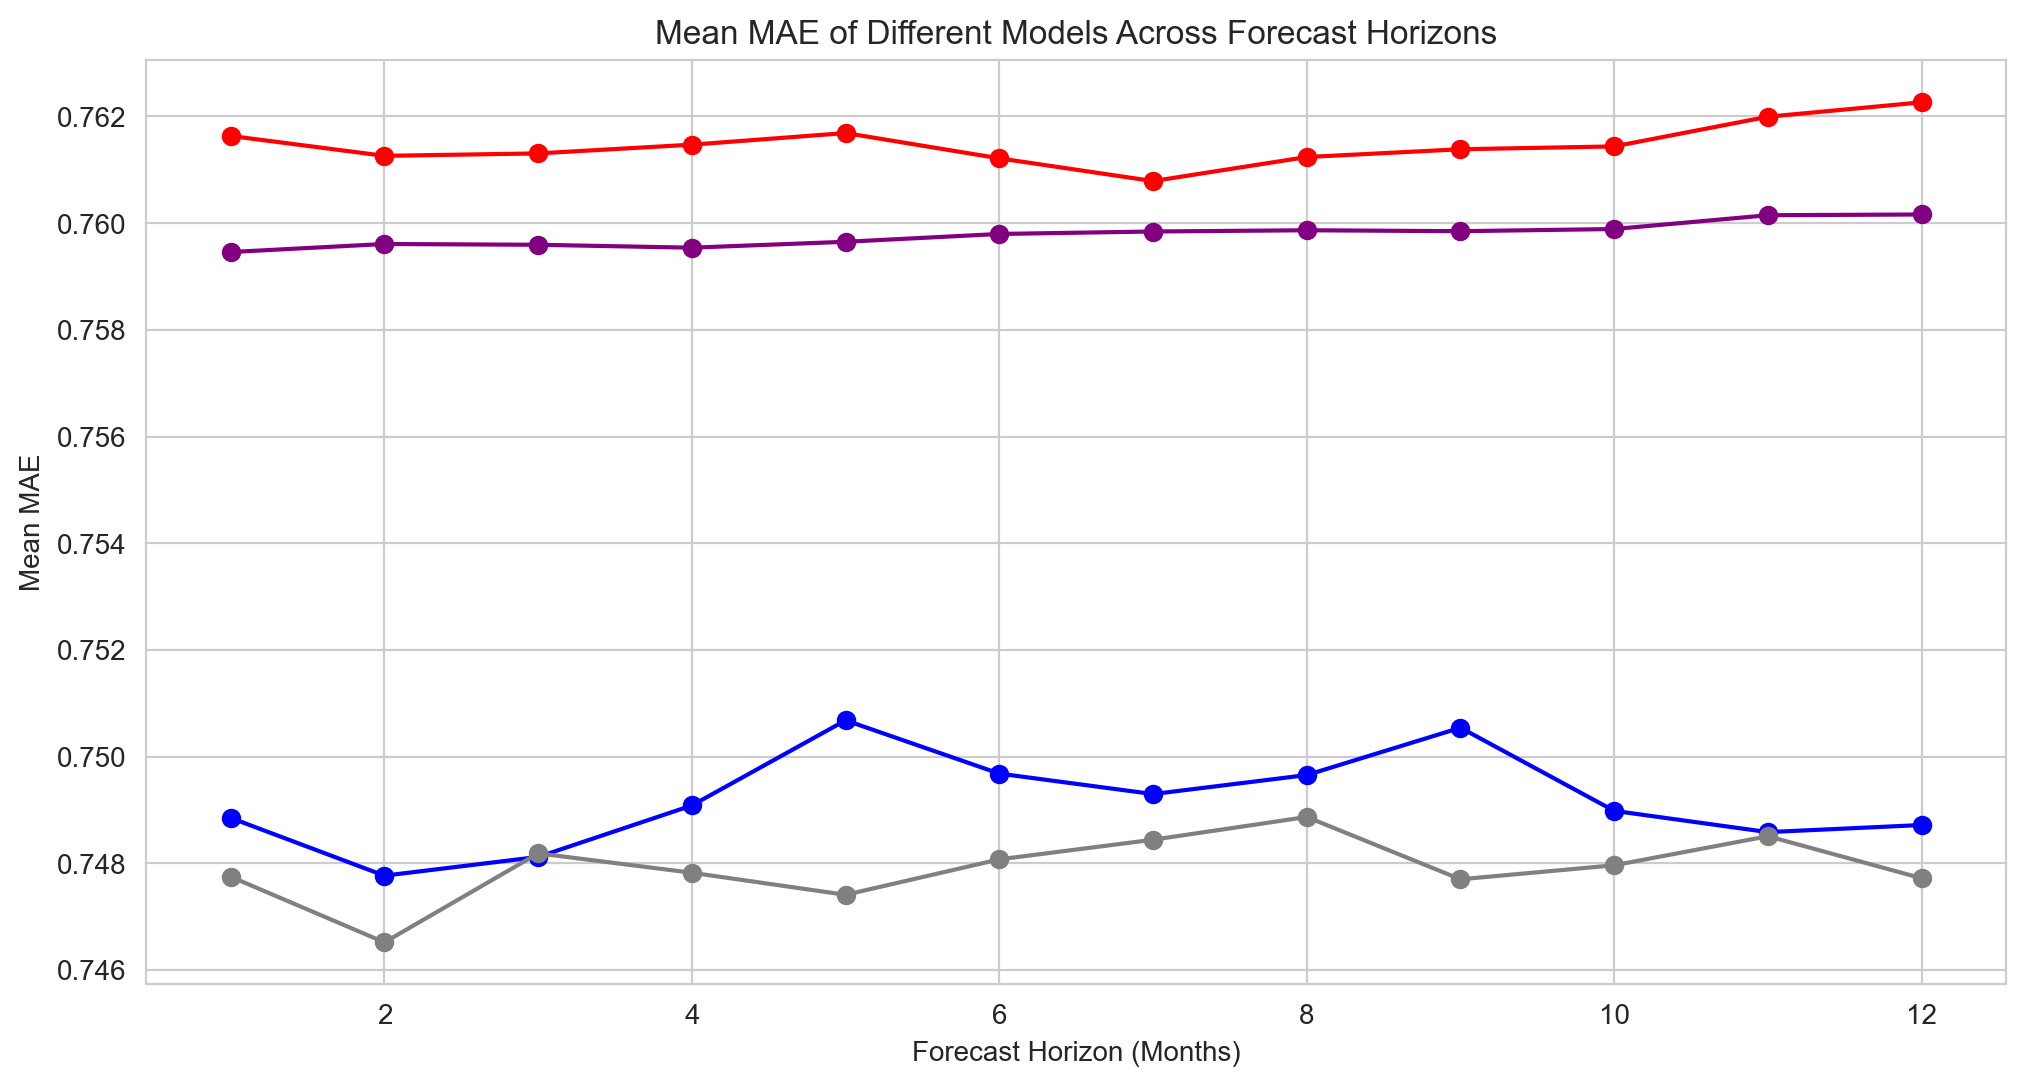

In [36]:

forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
models = ["CNN-LSTM", "CNN-LSTM + VS", "SARIMA", "ARIMA"]
mae_results = {}

# Populate mae_results from CSV files
for steps in forecast_horizons:
    filename_mae = f"maess_{steps}_month_ahead.csv"
    try:
        df_mae = pd.read_csv(os.path.join(m_result_Dir, filename_mae))
        mean_maes = df_mae.mean()
        mae_results[steps] = mean_maes.to_dict()
    except FileNotFoundError:
        print(f"Error: File '{filename_mae}' not found for {steps}-month ahead.")
        mae_results[steps] = {model: np.nan for model in models}

# Create the line plot
plt.figure(figsize=(12, 6))
colors = ['blue', 'gray', 'red', 'purple', 'green']  # Define colors for each model

for i, model in enumerate(models):
    mae_values = [mae_results[horizon].get(model, np.nan) for horizon in forecast_horizons]
    plt.plot(forecast_horizons, mae_values, marker='o', linestyle='-', color=colors[i], label=model)

# Customize the plot
plt.xlabel('Forecast Horizon (Months)')
plt.ylabel('Mean MAE')
plt.title('Mean MAE of Different Models Across Forecast Horizons')
plt.xticks

<function matplotlib.pyplot.xticks(ticks: 'ArrayLike | None' = None, labels: 'Sequence[str] | None' = None, *, minor: 'bool' = False, **kwargs) -> 'tuple[list[Tick] | np.ndarray, list[Text]]'>

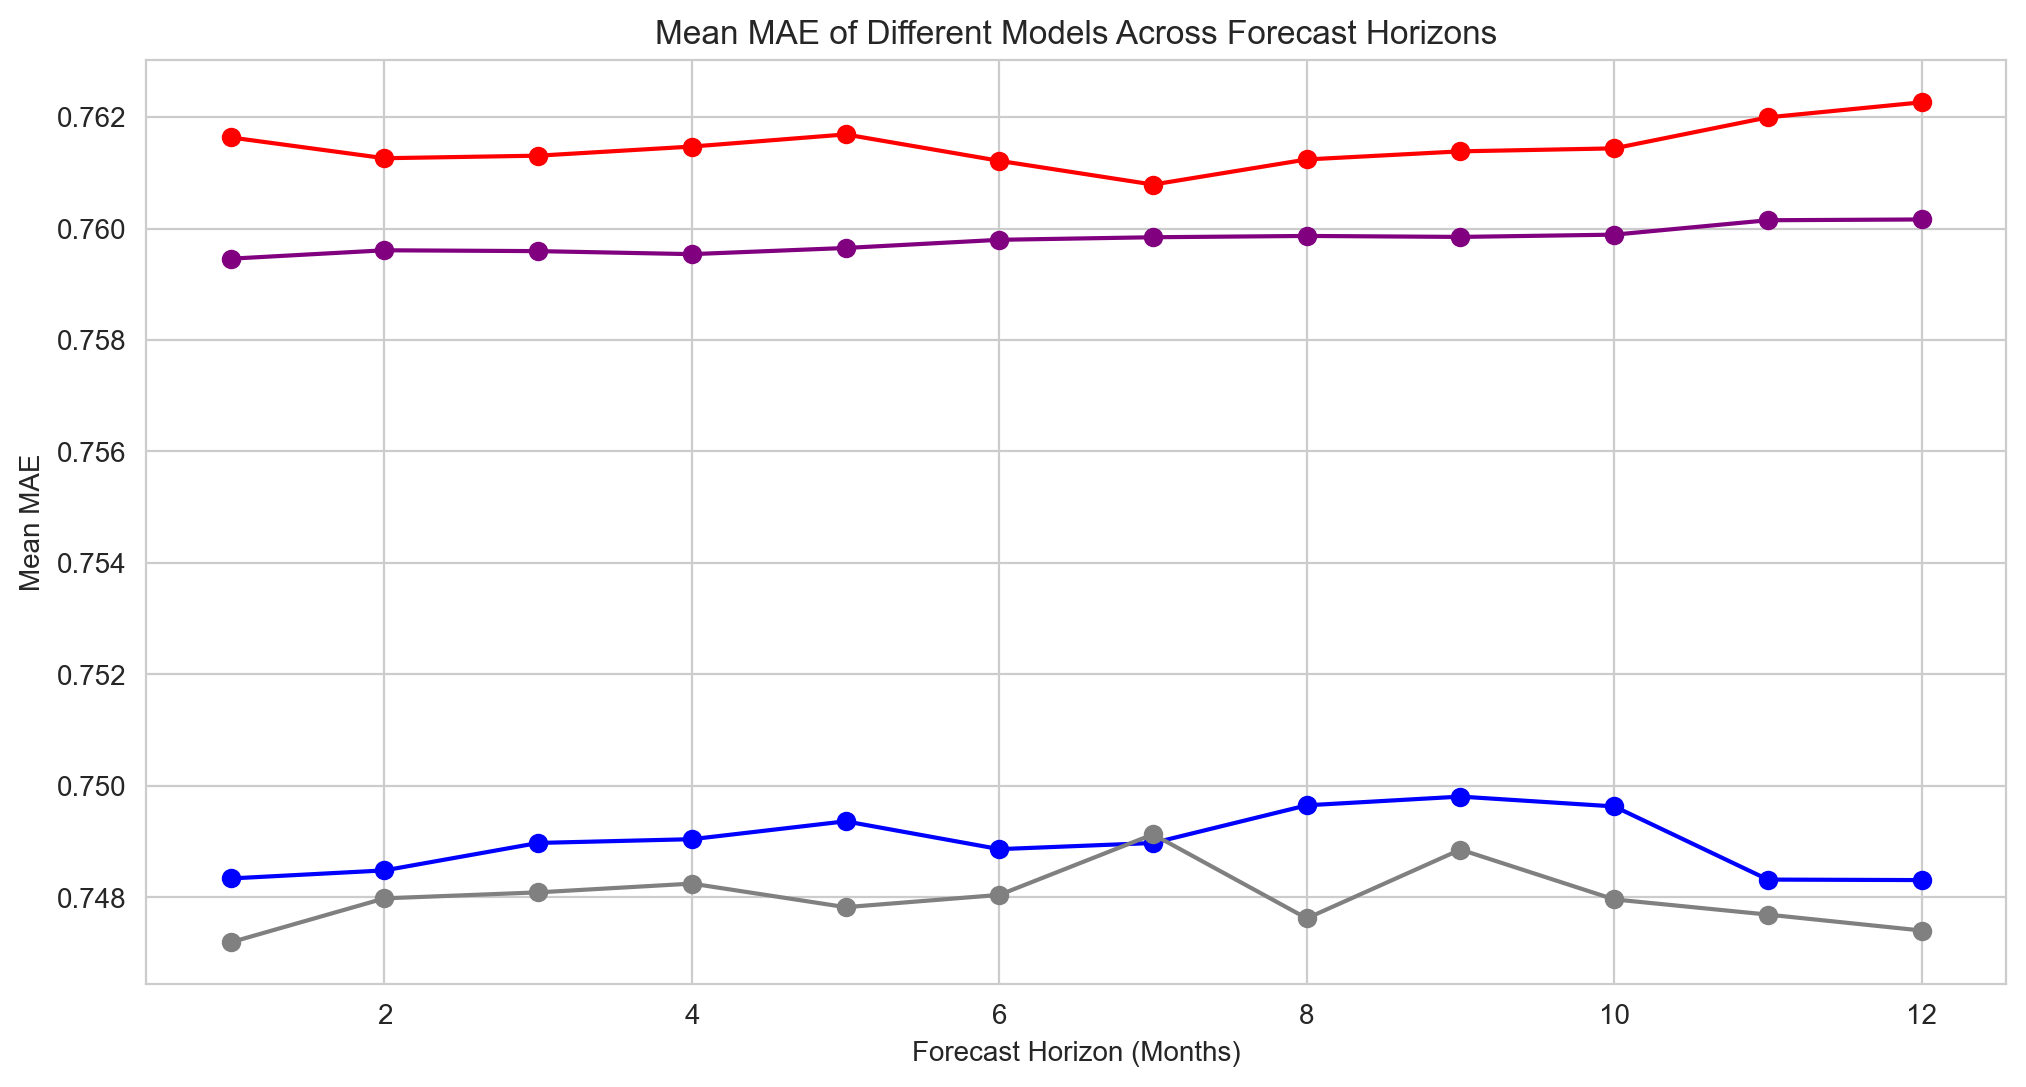

In [40]:

forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
models = ["CNN-LSTM", "CNN-LSTM + VS", "SARIMA", "ARIMA"]
mae_results = {}

# Populate mae_results from CSV files
for steps in forecast_horizons:
    filename_mae = f"maess_{steps}_month_ahead.csv"
    try:
        df_mae = pd.read_csv(os.path.join(m_result_Dir, filename_mae))
        mean_maes = df_mae.mean()
        mae_results[steps] = mean_maes.to_dict()
    except FileNotFoundError:
        print(f"Error: File '{filename_mae}' not found for {steps}-month ahead.")
        mae_results[steps] = {model: np.nan for model in models}

# Create the line plot
plt.figure(figsize=(12, 6))
colors = ['blue', 'gray', 'red', 'purple', 'green']  # Define colors for each model

for i, model in enumerate(models):
    mae_values = [mae_results[horizon].get(model, np.nan) for horizon in forecast_horizons]
    plt.plot(forecast_horizons, mae_values, marker='o', linestyle='-', color=colors[i], label=model)

# Customize the plot
plt.xlabel('Forecast Horizon (Months)')
plt.ylabel('Mean MAE')
plt.title('Mean MAE of Different Models Across Forecast Horizons')
plt.xticks

In [53]:

forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
models = ["CNN-LSTM", "CNN-LSTM + VS", "SARIMA", "ARIMA", "VAR"]

# Plot the distribution of MAEs for each forecast horizon
for steps in forecast_horizons:
    filename_mae = f"maess_{steps}_month_ahead.csv"
    try:
        df_maes = pd.read_csv(os.path.join(m_result_Dir, filename_mae))

        plt.figure(figsize=(10, 6))
        sns.histplot(df_maes["CNN-LSTM"], kde=True, bins=20, label="CNN-LSTM", color="blue", alpha=0.6)
        sns.histplot(df_maes["CNN-LSTM + VS"], kde=True, bins=20, label="CNN-LSTM + VS", color="cyan", alpha=0.6)
        sns.histplot(df_maes["VAR"], kde=True, bins=20, label="VAR", color="green", alpha=0.6)
        sns.histplot(df_maes["SARIMA"], kde=True, bins=20, label="SARIMA", color="red", alpha=0.6)
        sns.histplot(df_maes["ARIMA"], kde=True, bins=20, label="ARIMA", color="purple", alpha=0.6)

        plt.legend()
        plt.title(f"Distribution of MAE values for {steps}-Month Ahead Forecast")
        plt.xlabel("MAE")
        plt.ylabel("Frequency")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File '{filename_mae}' not found for {steps}-month ahead.")

In [52]:

forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
models = ["CNN-LSTM", "CNN-LSTM + VS", "SARIMA", "ARIMA", "VAR"]

for steps in forecast_horizons:
    filename_mae = f"maess_{steps}_month_ahead.csv"
    try:
        df_mae = pd.read_csv(os.path.join(m_result_Dir, filename_mae))

        print(f"\n--- Forecast Horizon: {steps}-Month Ahead ---")
        summary_data = {}
        for model in models:
            if model in df_mae.columns:
                summary_data[model] = {
                    "Average": df_mae[model].mean(),
                    "SD": df_mae[model].std(),
                    "Max": df_mae[model].max(),
                    "Min": df_mae[model].min(),
                }
            else:
                summary_data[model] = {
                    "Average": float('nan'),
                    "SD": float('nan'),
                    "Max": float('nan'),
                    "Min": float('nan'),
                }

        summary_df = pd.DataFrame.from_dict(summary_data, orient='index')
        # Sort the DataFrame by the 'Average' MAE column in ascending order
        summary_df_ordered = summary_df.sort_values(by="Average")
        print(summary_df_ordered)

    except FileNotFoundError:
        print(f"Error: File '{filename_mae}' not found for {steps}-month ahead.")


--- Forecast Horizon: 1-Month Ahead ---
                Average        SD       Max       Min
CNN-LSTM + VS  0.747191  0.076577  1.018302  0.594343
CNN-LSTM       0.748337  0.076704  1.025911  0.582631
ARIMA          0.759459  0.077824  1.016969  0.593711
SARIMA         0.761635  0.079499  1.027726  0.592276
VAR            1.021285  0.119745  1.271465  0.730224

--- Forecast Horizon: 2-Month Ahead ---
                Average        SD       Max       Min
CNN-LSTM + VS  0.747980  0.076896  1.021961  0.582286
CNN-LSTM       0.748481  0.076192  1.009561  0.583097
ARIMA          0.759610  0.077793  1.017386  0.593742
SARIMA         0.761262  0.079569  1.028440  0.592990
VAR            1.022295  0.099146  1.252034  0.807682

--- Forecast Horizon: 3-Month Ahead ---
                Average        SD       Max       Min
CNN-LSTM + VS  0.748087  0.076690  1.026867  0.583413
CNN-LSTM       0.748974  0.075487  1.025642  0.603447
ARIMA          0.759595  0.077748  1.017520  0.593065
SARIMA       

In [51]:

forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
models = ["CNN-LSTM", "CNN-LSTM + VS", "SARIMA", "ARIMA", "VAR"]

aggregated_stats = {model: {"Average": [], "SD": [], "Max": [], "Min": []} for model in models}

for steps in forecast_horizons:
    filename_mae = f"maess_{steps}_month_ahead.csv"
    try:
        df_mae = pd.read_csv(os.path.join(m_result_Dir, filename_mae))

        for model in models:
            if model in df_mae.columns:
                aggregated_stats[model]["Average"].append(df_mae[model].mean())
                aggregated_stats[model]["SD"].append(df_mae[model].std())
                aggregated_stats[model]["Max"].append(df_mae[model].max())
                aggregated_stats[model]["Min"].append(df_mae[model].min())
            else:
                aggregated_stats[model]["Average"].append(float('nan'))
                aggregated_stats[model]["SD"].append(float('nan'))
                aggregated_stats[model]["Max"].append(float('nan'))
                aggregated_stats[model]["Min"].append(float('nan'))

    except FileNotFoundError:
        print(f"Error: File '{filename_mae}' not found for {steps}-month ahead.")
        for model in models:
            aggregated_stats[model]["Average"].append(float('nan'))
            aggregated_stats[model]["SD"].append(float('nan'))
            aggregated_stats[model]["Max"].append(float('nan'))
            aggregated_stats[model]["Min"].append(float('nan'))

# Calculate the mean of each statistic across all horizons
final_summary_data = {}
for model, stats in aggregated_stats.items():
    final_summary_data[model] = {
        "Mean Average MAE": pd.Series(stats["Average"]).mean(),
        "Mean SD MAE": pd.Series(stats["SD"]).mean(),
        "Mean Max MAE": pd.Series(stats["Max"]).mean(),
        "Mean Min MAE": pd.Series(stats["Min"]).mean(),
    }

# Create a Pandas DataFrame from the final summary data
final_summary_df = pd.DataFrame.from_dict(final_summary_data, orient='index')

# Order the DataFrame by Mean Average MAE in ascending order
final_summary_df_ordered = final_summary_df.sort_values(by="Mean Average MAE")

print("\n--- Mean of Average, SD, Max, Min MAE Across All Horizons ---")
print(final_summary_df_ordered)


--- Mean of Average, SD, Max, Min MAE Across All Horizons ---
               Mean Average MAE  Mean SD MAE  Mean Max MAE  Mean Min MAE
CNN-LSTM + VS          0.748002     0.076910      1.021912      0.589240
CNN-LSTM               0.748978     0.076861      1.025772      0.588337
ARIMA                  0.759784     0.077805      1.017528      0.593698
SARIMA                 0.761474     0.079088      1.022552      0.595958
VAR                    1.038303     0.108480      1.338657      0.803477


In [69]:

forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
models = ["CNN-LSTM", "CNN-LSTM + VS", "SARIMA", "ARIMA", "VAR"]
alpha = 0.05  # Significance level
normality_results_all_horizons = {}

print("Normality Tests (Shapiro-Wilk) for Model Performance (MAE):\n")

# --- First Pass: Test for Normality ---
for steps in forecast_horizons:
    filename = f"maess_{steps}_month_ahead.csv"
    normality_results_for_horizon = {}
    try:
        df_maes = pd.read_csv(os.path.join(m_result_Dir, filename))
        print(f"--- Forecast Horizon: {steps}_month_ahead ---")
        for model in models:
            try:
                statistic, p_value = stats.shapiro(df_maes[model])
                is_normal = p_value > alpha
                normality_results_for_horizon[model] = is_normal
                print(f"  Model: {model}, Shapiro-Wilk Statistic: {statistic:.4f}, P-value: {p_value:.4f}, Likely Normal: {is_normal}")
            except Exception as e:
                print(f"  Error during normality test for {model}: {e}")
                normality_results_for_horizon[model] = False # Assume not normal if error
        normality_results_all_horizons[f"{steps}_month_ahead"] = normality_results_for_horizon
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found for {steps}-month ahead.\n")
        normality_results_all_horizons[f"{steps}_month_ahead"] = {model: False for model in models}

print("\nPairwise Significance Tests based on Normality (alpha=0.05):\n")


Normality Tests (Shapiro-Wilk) for Model Performance (MAE):

--- Forecast Horizon: 1_month_ahead ---
  Model: CNN-LSTM, Shapiro-Wilk Statistic: 0.9684, P-value: 0.0167, Likely Normal: False
  Model: CNN-LSTM + VS, Shapiro-Wilk Statistic: 0.9666, P-value: 0.0122, Likely Normal: False
  Model: SARIMA, Shapiro-Wilk Statistic: 0.9768, P-value: 0.0752, Likely Normal: True
  Model: ARIMA, Shapiro-Wilk Statistic: 0.9763, P-value: 0.0687, Likely Normal: True
  Model: VAR, Shapiro-Wilk Statistic: 0.9805, P-value: 0.1455, Likely Normal: True
--- Forecast Horizon: 2_month_ahead ---
  Model: CNN-LSTM, Shapiro-Wilk Statistic: 0.9743, P-value: 0.0477, Likely Normal: False
  Model: CNN-LSTM + VS, Shapiro-Wilk Statistic: 0.9695, P-value: 0.0204, Likely Normal: False
  Model: SARIMA, Shapiro-Wilk Statistic: 0.9753, P-value: 0.0564, Likely Normal: True
  Model: ARIMA, Shapiro-Wilk Statistic: 0.9762, P-value: 0.0673, Likely Normal: True
  Model: VAR, Shapiro-Wilk Statistic: 0.9872, P-value: 0.4502, Likel

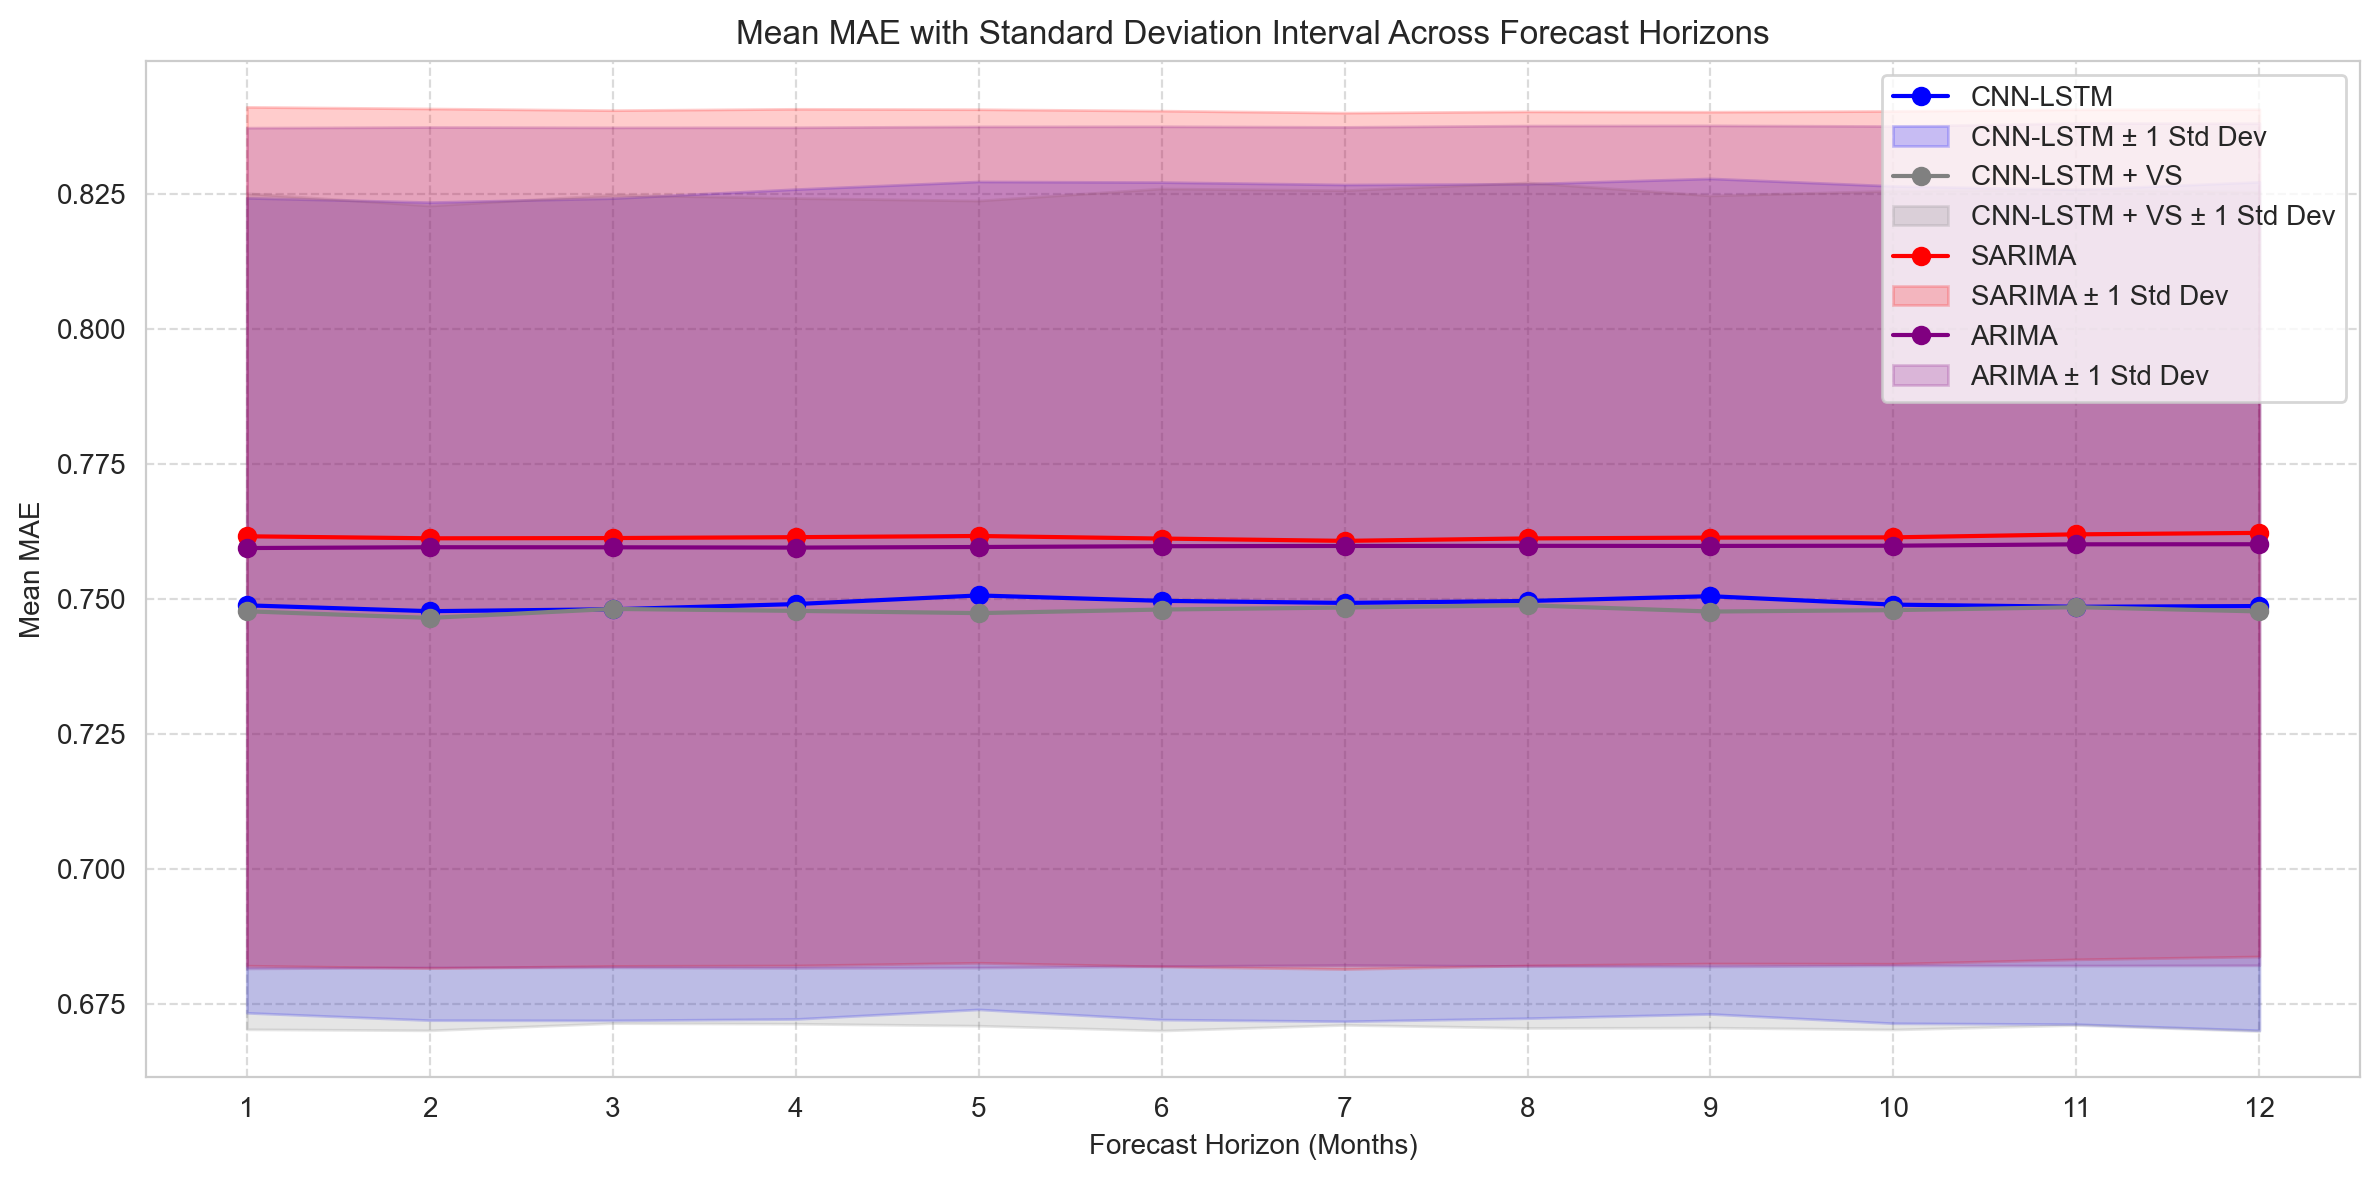

In [39]:

forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
models = ["CNN-LSTM", "CNN-LSTM + VS", "SARIMA", "ARIMA"]
mean_mae_results = {}
std_mae_results = {}

# Populate mean_mae_results and std_mae_results from CSV files
for steps in forecast_horizons:
    filename_mae = f"maess_{steps}_month_ahead.csv"
    try:
        df_mae = pd.read_csv(os.path.join(m_result_Dir, filename_mae))
        mean_mae_results[steps] = df_mae.mean().to_dict()
        std_mae_results[steps] = df_mae.std().to_dict()
    except FileNotFoundError:
        print(f"Error: File '{filename_mae}' not found for {steps}-month ahead.")
        mean_mae_results[steps] = {model: np.nan for model in models}
        std_mae_results[steps] = {model: np.nan for model in models}

# Create the line plot with confidence intervals
plt.figure(figsize=(12, 6))
colors = ['blue', 'gray', 'red', 'purple', 'green']  # Define colors for each model

for i, model in enumerate(models):
    mean_mae_values = [mean_mae_results[horizon].get(model, np.nan) for horizon in forecast_horizons]
    std_mae_values = [std_mae_results[horizon].get(model, np.nan) for horizon in forecast_horizons]

    # Plot mean MAE
    plt.plot(forecast_horizons, mean_mae_values, marker='o', linestyle='-', color=colors[i], label=model)

    # Plot confidence interval (using one standard deviation)
    lower_bound = np.array(mean_mae_values) - np.array(std_mae_values)
    upper_bound = np.array(mean_mae_values) + np.array(std_mae_values)
    plt.fill_between(forecast_horizons, lower_bound, upper_bound, color=colors[i], alpha=0.2, label=f'{model} ± 1 Std Dev')

# Customize the plot
plt.xlabel('Forecast Horizon (Months)')
plt.ylabel('Mean MAE')
plt.title('Mean MAE with Standard Deviation Interval Across Forecast Horizons')
plt.xticks(forecast_horizons)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [9]:

# # --- Second Pass: Perform Significance Tests ---
# for steps in forecast_horizons:
#     filename = f"maess_{steps}_month_ahead.csv"
#     horizon_str = f"{steps}_month_ahead"
#     normality_results = normality_results_all_horizons.get(horizon_str, {})
#     try:
#         df_maes = pd.read_csv(os.path.join(m_result_Dir, filename))
#         print(f"--- Forecast Horizon: {horizon_str} ---")
#         for i in range(len(models)):
#             for j in range(i + 1, len(models)):
#                 model1 = models[i]
#                 model2 = models[j]
# 
#                 print(f"\nComparison: {model1} vs {model2}")
# 
#                 normal_model1 = normality_results.get(model1, False)
#                 normal_model2 = normality_results.get(model2, False)
# 
#                 try:
#                     if normal_model1 and normal_model2:
#                         # Perform Paired t-test if both are likely normal
#                         result = stats.ttest_rel(df_maes[model1], df_maes[model2])
#                         p_value = result.pvalue
#                         statistic = result.statistic
#                         test_type = "Paired t-test"
#                     else:
#                         # Perform Wilcoxon signed-rank test if at least one is not normal
#                         result = stats.wilcoxon(df_maes[model1], df_maes[model2])
#                         p_value = result.pvalue
#                         statistic = result.statistic
#                         test_type = "Wilcoxon Signed-Rank Test"
# 
#                     if p_value < alpha:
#                         significance = "Significant"
#                     else:
#                         significance = "Not Significant"
# 
#                     print(f"  Test Used: {test_type}")
#                     print(f"  Statistic: {statistic:.4f}")
#                     print(f"  P-value: {p_value:.4f}")
#                     print(f"  Difference is {significance} (alpha={alpha})\n")
# 
#                 except ValueError as e:
#                     print(f"  Error comparing {model1} and {model2}: {e}. Likely due to identical values.")
#                     print("  Consider inspecting the data.\n")
# 
#     except FileNotFoundError:
#         print(f"Error: File '{filename}' not found for {horizon_str}.\n")
# 
# print("\nNote: Shapiro-Wilk test checks if the data is likely drawn from a normal distribution (alpha=0.05).")
# print("Pairwise significance tests are chosen based on these normality test results.")

--- Forecast Horizon: 1_month_ahead ---

Comparison: CNN-LSTM vs CNN-LSTM + VS
  Test Used: Paired t-test
  Statistic: 2.6121
  P-value: 0.0104
  Difference is Significant (alpha=0.05)


Comparison: CNN-LSTM vs SARIMA
  Test Used: Paired t-test
  Statistic: -3.6728
  P-value: 0.0004
  Difference is Significant (alpha=0.05)


Comparison: CNN-LSTM vs ARIMA
  Test Used: Paired t-test
  Statistic: -4.0456
  P-value: 0.0001
  Difference is Significant (alpha=0.05)


Comparison: CNN-LSTM vs VAR
  Test Used: Paired t-test
  Statistic: -16.4166
  P-value: 0.0000
  Difference is Significant (alpha=0.05)


Comparison: CNN-LSTM + VS vs SARIMA
  Test Used: Paired t-test
  Statistic: -4.5081
  P-value: 0.0000
  Difference is Significant (alpha=0.05)


Comparison: CNN-LSTM + VS vs ARIMA
  Test Used: Paired t-test
  Statistic: -5.0790
  P-value: 0.0000
  Difference is Significant (alpha=0.05)


Comparison: CNN-LSTM + VS vs VAR
  Test Used: Paired t-test
  Statistic: -16.8007
  P-value: 0.0000
  Diffe